# Model: backbones

"A backbone performs further feature abstraction based on the preliminary features extracted by the grid encoder" ([https://arxiv.org/abs/2305.04925](https://arxiv.org/abs/2305.04925)).

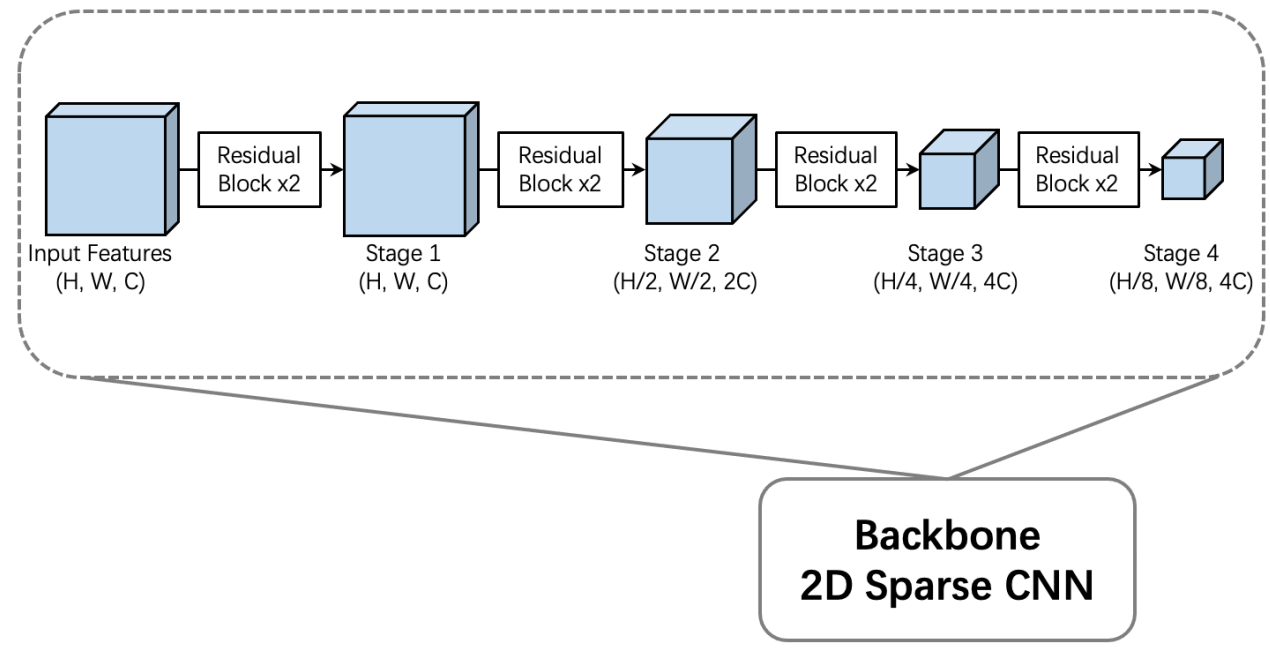

The following classes form the backbone of the network in the object detection pipeline. The backbone is responsible for refining and abstracting features extracted by the initial grid or voxel encoder (`model_readers`), ensuring that the subsequent detection layers have rich, informative features to work with. Using sparse convolutions in these backbones is important, as LiDAR data is inherently sparse, with many regions containing no information.

In [ ]:
#| default_exp models/model_backbones

In [ ]:
#|export
import torch
from torch import nn
import spconv
import spconv.pytorch
from spconv.pytorch import SparseSequential, SparseConv2d, SparseConv3d
from pillarnext_explained.models.model_utils import SparseConvBlock, SparseBasicBlock, SparseConv3dBlock, SparseBasicBlock3d


## Sparse ResNet

In [ ]:
#|exports
class SparseResNet(spconv.pytorch.SparseModule):
    """
    SparseResNet is a neural network model built using sparse convolutions for processing sparse input data, like LiDAR point cloud processing.
    """
    def __init__(
            self,
            layer_nums: list, # Number of blocks in each layer
            ds_layer_strides: list, # Strides for each downsampling layer
            ds_num_filters: list, # Number of filters for each downsampling layer
            num_input_features: int, # Number of input features
            kernel_size: list = [3, 3, 3, 3], # Kernel sizes for each layer
            out_channels: int = 256 # Number of output channels
            ):

        super(SparseResNet, self).__init__()  # Call the constructor of the parent class
        self._layer_strides = ds_layer_strides  # Store the layer strides
        self._num_filters = ds_num_filters  # Store the number of filters for each layer
        self._layer_nums = layer_nums  # Store the number of blocks in each layer
        self._num_input_features = num_input_features  # Store the number of input features

        # Ensure the lengths of the strides, filters, and layer numbers are consistent
        assert len(self._layer_strides) == len(self._layer_nums)
        assert len(self._num_filters) == len(self._layer_nums)

        # Define the number of input filters for each layer
        in_filters = [self._num_input_features, *self._num_filters[:-1]]
        blocks = []  # Initialize the list to hold all the blocks

        # Create the layers for the network
        for i, layer_num in enumerate(self._layer_nums):
            block = self._make_layer(
                in_filters[i],
                self._num_filters[i],
                kernel_size[i],
                self._layer_strides[i],
                layer_num)
            blocks.append(block)  # Add the created block to the blocks list

        # Convert blocks list to a PyTorch ModuleList for proper handling in forward pass
        self.blocks = nn.ModuleList(blocks)

        # Create the final mapping layer
        self.mapping = spconv.pytorch.SparseSequential(
            spconv.SparseConv2d(self._num_filters[-1],
                                out_channels, 1, 1, bias=False),  # 1x1 convolution
            nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.01),  # Batch normalization
            nn.ReLU(),  # Activation function
        )

    def _make_layer(self, inplanes, planes, kernel_size, stride, num_blocks):
        """
        Helper function to create a layer consisting of several blocks.
        """
        layers = []
        # Add the first convolutional block with stride (downsampling)
        layers.append(SparseConvBlock(inplanes, planes,
                      kernel_size=kernel_size, stride=stride, use_subm=False))

        # Add subsequent blocks without stride
        for j in range(num_blocks):
            layers.append(SparseBasicBlock(planes, kernel_size=kernel_size))

        # Return the layers as a SparseSequential module
        return spconv.pytorch.SparseSequential(*layers)

    def forward(self, pillar_features, coors, input_shape):
        """
        Forward pass of the network.
        """
        # Determine batch size from the unique coordinates
        batch_size = len(torch.unique(coors[:, 0]))
        # Create a SparseConvTensor from the input features, coordinates, and shape
        x = spconv.pytorch.SparseConvTensor(
            pillar_features, coors, input_shape, batch_size)
        
        # Pass the tensor through each block sequentially
        for i in range(len(self.blocks)):
            x = self.blocks[i](x)
        
        # Apply the final mapping
        x = self.mapping(x)
        # Convert the sparse tensor to a dense tensor and return
        return x.dense()

The `SparseResNet` class extends from `spconv.pytorch.SparseModule`, which is part of the `spconv` library. This library provides specialized operations for sparse data, particularly useful in scenarios where the input data is not densely populated, as is the case with LiDAR point clouds.

- **Layer Construction:**
  - The class constructs layers using a helper function `_make_layer`, which creates blocks consisting of sparse convolutional layers.
  - The `blocks` attribute is a `ModuleList` of all the layers in the network, enabling sequential processing in the forward pass.

- **Mapping Layer:**
  - After passing through all the blocks, the data goes through a final mapping layer that performs a 1x1 sparse convolution, batch normalization, and ReLU activation.

- **Layer Construction (`_make_layer` Method):**
  - This method creates a layer with multiple blocks. The first block includes downsampling (through stride), and the subsequent blocks are added without additional downsampling.

- **Forward Pass (`forward` Method):**
  - The forward pass involves creating a `SparseConvTensor` from the input features, coordinates, and input shape.
  - The tensor is passed through each block sequentially.
  - Finally, the sparse tensor is mapped to the output channels and converted to a dense tensor before being returned.

## Sparse ResNet 3D

In [ ]:
#|exports
class SparseResNet3D(spconv.pytorch.SparseModule):
    """
    SparseResNet3D is a 3D variant of the SparseResNet model, designed for processing 3D sparse input data.
    """
    def __init__(
        self,
        layer_nums: list,  # Number of blocks in each layer
        ds_layer_strides: list,  # Strides for each downsampling layer
        ds_num_filters: list,  # Number of filters for each downsampling layer
        num_input_features: int,  # Number of input features
        kernel_size: list = [3, 3, 3, 3],  # Kernel sizes for each layer
        out_channels: int = 128  # Number of output channels
    ):
        super(SparseResNet3D, self).__init__()
        
        # Initialize the instance variables
        self._layer_strides = ds_layer_strides
        self._num_filters = ds_num_filters
        self._layer_nums = layer_nums
        self._num_input_features = num_input_features

        # Ensure the lengths of the lists match
        assert len(self._layer_strides) == len(self._layer_nums)
        assert len(self._num_filters) == len(self._layer_nums)

        # List of input filters for each layer
        in_filters = [self._num_input_features, *self._num_filters[:-1]]
        blocks = []

        # Create layers based on the given parameters
        for i, layer_num in enumerate(self._layer_nums):
            block = self._make_layer(
                in_filters[i],
                self._num_filters[i],
                kernel_size[i],
                self._layer_strides[i],
                layer_num)
            blocks.append(block)

        # Store the blocks in a ModuleList
        self.blocks = nn.ModuleList(blocks)
        
        # Define the mapping layer
        self.mapping = SparseConv3dBlock(
            self._num_filters[-1], out_channels, kernel_size=1, stride=1, use_subm=True)
        
        # Define the extra convolutional layer
        self.extra_conv = SparseSequential(
            SparseConv3d(
                self._num_filters[-1], self._num_filters[-1], (3, 1, 1), (2, 1, 1), bias=False),
            nn.BatchNorm1d(self._num_filters[-1], eps=1e-3, momentum=0.01),
            nn.ReLU(),
        )

    def _make_layer(self, inplanes, planes, kernel_size, stride, num_blocks):
        """
        Creates a single layer composed of sparse 3D convolution blocks.
        """

        layers = []
        
        # Add the first convolution block with downsampling
        layers.append(SparseConv3dBlock(inplanes, planes,
                      kernel_size=kernel_size, stride=stride, use_subm=False))

        # Add the remaining blocks without downsampling
        for _ in range(num_blocks):
            layers.append(SparseBasicBlock3d(planes, kernel_size=kernel_size))

        return spconv.pytorch.SparseSequential(*layers)

    def forward(self, pillar_features, coors, input_shape):
        # Get the batch size from the unique coordinates
        batch_size = len(torch.unique(coors[:, 0]))
        
        # Create a sparse tensor
        x = spconv.pytorch.SparseConvTensor(
            pillar_features, coors, input_shape, batch_size)
        
        # Pass the tensor through the blocks
        for i in range(len(self.blocks)):
            x = self.blocks[i](x)
        
        # Apply the extra convolution and mapping layers
        x = self.extra_conv(x)
        x = self.mapping(x)
        
        # Convert the sparse tensor to a dense format
        x = x.dense()
        
        # Reshape the output tensor
        B, C, D, H, W = x.shape
        x = x.view(B, C * D, H, W)
        
        return x

The `SparseResNet3D` class extends the functionality of `SparseResNet` to 3D data, making it suitable for voxel-based encoders that operate directly on 3D grids of LiDAR data.

**Implementation Details:**

- **3D Convolutional Layers:** Like the 2D variant, `SparseResNet3D` uses multiple layers composed of sparse 3D convolutional blocks. The blocks are similar in structure to the 2D version but adapted to 3D operations.
- **Extra Convolutional Layer:** An additional convolutional layer is added before the final mapping to further enhance the feature representation.
- **Forward Pass:** Similar to `SparseResNet`, the input features are processed through each block and additional layers, with the output converted from sparse to dense format. The final tensor is reshaped to accommodate the 3D nature of the input.